# Using Deep Transfer Learning to detect COVID-19

Can we use Deep Learning to analyze a set of chest XRays of known COVID-19 patients to detect when a patient has COVID-19.

The work and information in this notebook is inspired by a [blog post](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/) by Adrian Rosebrock on his website [PyImageSearch](www.pyimagesearch.com)

In that blog post, Adrian shows how to apply transfer learning using the [VGG16 Convolution Neural Network](https://neurohive.io/en/popular-networks/vgg16/) using the network weights from the ImageNet dataset.  

My contribution to that great blog post is to go into some detail on what transfer learning is and why it was so powerful in this application.  I will then show how we can use other Deep Learning Convolutional networks for transfer learning and their performance on the same dataset.

Lastly we will look at how a model trained on the COVID-19 XRay images does against images of normal chest XRays and chest XRays of those with Pneumonia to see if the model can accurately detect that chest XRay is NOT COVID-19.


<font color="red" size="5">Like Adrian, I want to be very clear that the information here, and derived from [Adrian's](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/) blog post is meant for Deep Learning educational purposes only.  In no way is it implied that this technique should be used for the identification of COVID-19.</font>

## DataSets

### COVID-19 Image Dataset

There is a Github repo started by Joseph Paul Cohen called [covid-chestxray-dataset](https://github.com/ieee8023/covid-chestxray-dataset).  

![Covid19Share](./notebook_images/covid19-share-image.png)

From the README.md file in that Github repo:

`We are building a database of COVID-19 cases with chest X-ray or CT images. We are looking for COVID-19 cases as well as MERS, SARS, and ARDS.`

We will use this dataset to have a model learn what a chest XRay looks like that has COVID-19.

This dataset is updated frequently.  New images were added as I was working with the dataset so check back often.

### Kaggle Chest X-Ray Images (Pneumonia)

[Kaggle](www.kaggle.com) is an online community of people interested in data science.  It allows users to find, publish, explore and build models around datasets made available to the public.  

The dataset we will use is the [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) dataset.  This dataset has chest X-Ray images of normal lungs as well as chest X-Ray images of lungs with Pneumonia.

We can use this dataset to train the model on what normal chest X-Rays look like.

### Visual Inspect of Datasets

<br>
<table>
  <tr style="text-align:center; background-color:white">
    <td> <img src="./notebook_images/covid19-collage.png" alt="COVID" style="width: 400px;"/></td>
    <td> <img src="./notebook_images/normal-collage.png" alt="NORMAL" style="width: 400px;"/> </td>
    <td> <img src="./notebook_images/pneumonia-collage.png" alt="PNEU" style="width: 400px;"/> </td>
  </tr>
  <tr style="width:100%;">
    <td style="width:20%;"> <p style="font-family:overpass;font-size:16px;text-align:center;color:#303030;font-weight:300;">COVID-19</p> </td>
    <td style="width:20%;"> <p style="font-family:overpass;font-size:16px;text-align:center;color:#303030;font-weight:300;">NORMAL</p> </td>
    <td style="width:20%;"> <p style="font-family:overpass;font-size:16px;text-align:center;color:#303030;font-weight:300;">PNEUMONIA</p> </td>

  </tr>
</table>

<br>


### Caveats

I would like to stress that the datasets being used are not vetted by myself or as far as I know, anyone with expertise in the field.  We are using datasets from disparate sources, collected at different times with different procedures.  I have no way of knowing if the image is really of a COVID-19 Chest X-Ray, or some other ailament that resembles COVID-19.

So take this exercise as an interesting use case of applying Deep Transfer Learning to a set of images for classification.  

## What is Deep Transfer Learning - Fine Tuning

Convolutional Neural Networks (CNNs) are commonly used when working with images and Deep Learning.

Think of a convolution as a small, 3x3 or 5x5, etc, mathematical matrix that is applied to an image to alter the image.  We use convolutions all time when using image processing software to sharpen or blur an image.  

A CNN model will be made up of some number of convolutional layers.  Each layer will have a different number of kernels ( small matrix we talked about ), and a final fully connected network (FCN) layer that will be used to perform the actual classification step.

The initial convolutional layers, also called the convolutional base, act as a feature extraction layer.  This layer is attempting to identify the features in a dataset and for an image that might be interesting parts of the images. According to Francois Chollet the creator of Keras from his book Deep Learning with Python,

`... the representations learned by the convolutional base as likely to be more generic [than the fully connected layer] and therefore more reusable; the feature maps of the convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the conputer-vision problem at hand.`

This means that the convolution layers can be trained to identify interesting features based on how the model was trained.  This does imply that the model was trained on images with some commonality to the new problem.

`So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using on the first few layers of the model to do feature extraction, rather than using the entire convolutional base`.

The representation learned by the fully connected network layer will be specific to the new dataset that the model is trained on, as it will only contain information about the set of possible outcomes.





![CNN Arch](notebook_images/A-convolutional-neural-networks-CNN.png)

<br>
<br>

<span><font size="2">
    A New Method for Face Recognition Using Convolutional Neural Network - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/A-convolutional-neural-networks-CNN_fig6_321286547 [accessed 18 Mar, 2020]
    </font></span>

This means we can use a trained model leveraging all of the time and data it took for training the convolutional part, and just remove the FCN layer.  

A properly trained CNN requires a lot of data and CPU/GPU time.  If our dataset is small, we cannot start from a fresh CNN model and try to train it and hope for good results. 

![cnnlayer](notebook_images/ccn_layer.png)

Leveraging the frozen CNN layer, we just have to train a new fully connected layer.  This requires much less CPU and while we would like as much data as is possible, we can obtain very good results with less data on the fully connected layer.

![cnnlayer](notebook_images/cnn_new_fcn.png)

## Applying Deep Transfer Learning

We will be using Tensorflow and Keras to build out a model for the COVID-19 Chest X-Ray detection.  

Keras comes with a number of models with their pre-configured architecture.  You can find out more about the Keras models [here](https://keras.io/applications/).  Pre-configured means that the exact architecture in terms of the number of layers and number of kernels is already configured.  But these models have no weights.  It is the training process that determines the weights to use, however, we can use the weights that have already be determined to work well using large amounts of image data.  For that we will use the imagenet weights for each of the models.

[ImageNet](http://imagenet.stanford.edu) is an image database of millions of images.  These images were used to train the model architectures and those best model weights can be made available so that we do not have to train a model from nothing.



We are going to look at 4 Keras models:

* VGG16 This was also the model that Adrian used in his [blog post](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/).  More information can be found [here](https://arxiv.org/abs/1409.1556)

* VGG19  More information can be found [here](https://arxiv.org/abs/1409.1556)

* ResNet50  More information can be found [here](https://arxiv.org/abs/1512.03385)

* ResNet50V2  More information can be found [here](https://arxiv.org/abs/1603.05027)

The exact details of the models can be found from the links above

## Implementation Details

In [ ]:
from build_covid_dataset import create_covid_dataset
from sample_kaggle_dataset import create_kaggle_dataset

### COVID-19 Dataset

Go to github and clone the repository:

https://github.com/ieee8023/covid-chestxray-dataset

The function `create_covid_dataset`, will read the manifest file and pull out all of the COVID19 images and copy those to the specified output directory.


In [ ]:
covid_github_dir = '/Volumes/MacBackup/covid-chestxray-dataset'
covid_output_dir = './dataset/0318/covid'

In [ ]:
covid_file_count = create_covid_dataset(covid_github_dir, covid_output_dir)
covid_file_count

### Kaggle Dataset

You will have to have a Kaggle account to download the dataset.  

The function `create_kaggle_dataset` will take a random sample from the dataset directory specified and put those images into the output directory.  For this experiment we are only taking images from the NORMAL training set.

In [ ]:
kaggle_dataset_dir = '/Volumes/MacBackup/kaggle-chest-x-ray-images/chest_xray/train/NORMAL'
normal_output_dir = './dataset/0318/normal'

In [ ]:
create_kaggle_dataset(kaggle_dataset_dir, normal_output_dir, covid_file_count)

### Setting up VGG16 for transfer learning

To setup the Deep Learning models for transfer learning, we have to remove the fully connected layer.  Create the VGG16 class and specify the weights as 'imagenet' weights and include_top=False.  This will pre-initialize all of the weights to be those trained on the ImageNet dataset, and remove the top FCN layer.

```python
baseModel = VGG16(weights="imagenet", include_top=False,
     						input_tensor=Input(shape=(224, 224, 3)))
```

Now we need to add our own FCN layer that wont have any weights.  The new weights for the FCN layer will need to be learned by training the model on the new Chest X-Ray data.

```python
    # construct the head of the model that will be placed on top of the
    # the base model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(2, activation="softmax")(headModel)
    # place the head FC model on top of the base model (this will become
    # the actual model we will train)
    model = Model(inputs=baseModel.input, outputs=headModel)

```

The FCN defined above is taken directly from the blog post, but there is nothing particularly special about that configuration.  This is an area for research to determine the optimal FCN.

Finally we create a model which is the combination of the baseModel which is the CNN and the new FCN model for the outputs.

Recall however that when we train the model, we do <b>NOT</b> want to re-train the weights for the baseModel.  We want to use the imagenet weights.  To do that we need to freeze the baseModel.

```python
    for layer in baseModel.layers:
        layer.trainable = False

```

Keras has a number of models, and it becomes very easy for us to try many different models to see which will perform best.  

To evaluate multiple models, I have refactored the original implementation to take a collection of models.

```python
        MODELS = [
            {
                "base_model": VGG16(weights="imagenet", include_top=False,
                                    input_tensor=Input(shape=(224, 224, 3))),
                "name": "vgg16"
            },
            {
                "base_model": VGG19(weights="imagenet", include_top=False,
                                    input_tensor=Input(shape=(224, 224, 3))),
                "name": "vgg19"
            },
            {
                "base_model": ResNet50(weights="imagenet", include_top=False,
                                       input_tensor=Input(shape=(224, 224, 3))),
                "name": "resnet50"

            },
            {
                "base_model": ResNet50V2(weights="imagenet", include_top=False,
                                       input_tensor=Input(shape=(224, 224, 3))),
                "name": "resnet50v2"

            }
        ]

```

We are going to evaluate 4 models, using the same FCN to see how each model performs against the dataset.

You can find the full implementation of my version of the training script in my Github repository.

For a full explaination of Adrians approach please see his [blog post](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/) .  

### Train the models

Even though we are only training the small FCN layers, it can take some time.  If you do not want to train all 4 models, then I recommend you pass a models parameter to the `train_covid_model` function with a single value.  For example:

```python
        MODELS = [
            {
                "base_model": ResNet50V2(weights="imagenet", include_top=False,
                                       input_tensor=Input(shape=(224, 224, 3))),
                "name": "resnet50v2"

            }
        ]

train_covid_model('./dataset/0318', MODELS)

```



In [1]:
from train_covid19 import train_covid_model

[INFO] loading images...
['covid' 'normal']
---------------------------------------------------
Running Model: vgg16
[INFO] compiling model...
[INFO] training head...
Epoch 1/2
13/13 - 44s - loss: 0.6552 - accuracy: 0.5876 - val_loss: 0.5690 - val_accuracy: 0.6667
Epoch 2/2
13/13 - 46s - loss: 0.5070 - accuracy: 0.7404 - val_loss: 0.4602 - val_accuracy: 0.8889
[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      0.77      0.87        13
      normal       0.82      1.00      0.90        14

    accuracy                           0.89        27
   macro avg       0.91      0.88      0.89        27
weighted avg       0.91      0.89      0.89        27

[[10  3]
 [ 0 14]]
acc: 0.8889
sensitivity: 0.7692
sensitivity, aka recall or true positive rate indicates that when
    the model says the patient was positive for COVID-19, how often was it correct.  This does not
    mean that it found all of the COVID-19 cases, just that when 

/Users/patrickryan/.local/share/virtualenvs/py37_tf2_deeplearning_venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       covid       0.48      1.00      0.65        13
      normal       0.00      0.00      0.00        14

    accuracy                           0.48        27
   macro avg       0.24      0.50      0.33        27
weighted avg       0.23      0.48      0.31        27

[[13  0]
 [14  0]]
acc: 0.4815
sensitivity: 1.0000
sensitivity, aka recall or true positive rate indicates that when
    the model says the patient was positive for COVID-19, how often was it correct.  This does not
    mean that it found all of the COVID-19 cases, just that when it predicted COVID-19 how accurate was it.
specificity: 0.0000
specificity, aka precision or true negative, measures the proportion of actual negatives that are correctly
    identified.  The percentage of healthy people who are correctly identified as NOT having the
    condition. If this is not 1.0, then the model falsely said a patient
    was healthy, and free from COVID-19, when in fa

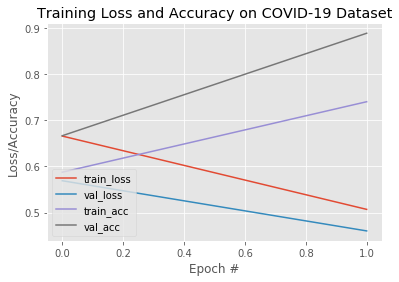

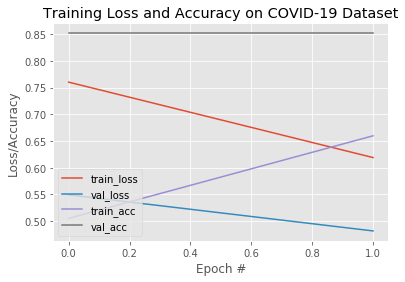

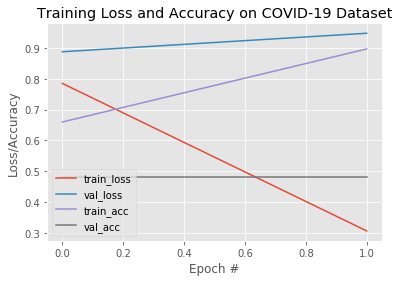

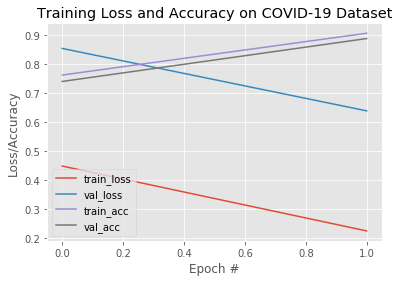

In [2]:
train_covid_model('./dataset/0318')